**Good data is the foundation for creating a better model. It's like having a solid base for building something great.**

In [1]:
# Install libraries
!pip install -q datasets transformers sentence_transformers faiss-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 40.1 MB/s eta 0:00:00


In [2]:
from google.colab import userdata

# Defined in the secrets tab in Google Colab
hf_token = userdata.get('huggingface')

In [3]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("ttbui/html_alpaca")
dataset

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input', 'instruction', 'output', 'response'],
        num_rows: 636
    })
})

In [4]:
# Read as pandas DataFrame
dataset['train'].to_pandas()

,input,instruction,output,response
0,,Generate the HTML code for a page with a cente...,<html>\n <head>\n <title>My Portfolio</tit...,None
1,<html>\n<head>\n <title>My Web Page</title>...,Edit the following HTML structure to include t...,<html>\n<head>\n <title>My Web Page</title>...,None
2,,Create an HTML page containing a login form wi...,<html>\n <head>\n <title>Login Form</title>\n...,None
3,,Create an HTML page with a text input form and...,<html>\n <head>\n <title>Text Input Form</tit...,None
4,,Write an HTML page that displays a table conta...,<html>\n<head>\n <title>Example Table</title>...,None
...,...,...,...,...
631,,Please generate a html. Can you create an emai...,<!DOCTYPE html>\n<html>\n<head>\n<title>Nutrit...,None
632,,Please generate a html. I want an email templa...,<!DOCTYPE html>\n<html>\n<head>\n<title>Custom...,None
633,,Please generate a html. I need an email templa...,<!DOCTYPE html>\n<html>\n<head>\n<title>Travel...,None
634,,Please generate a html. Can you create an emai...,<!DOCTYPE html>\n<html>\n<head>\n<title>Custom...,None


tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

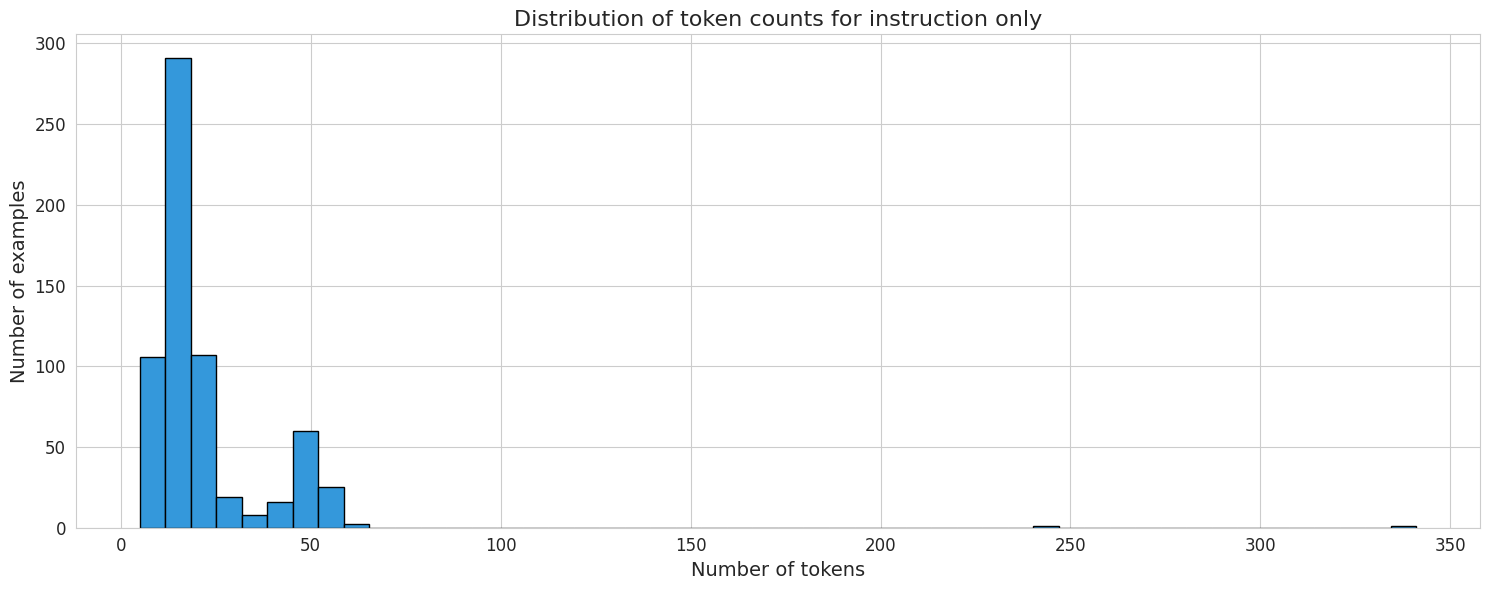

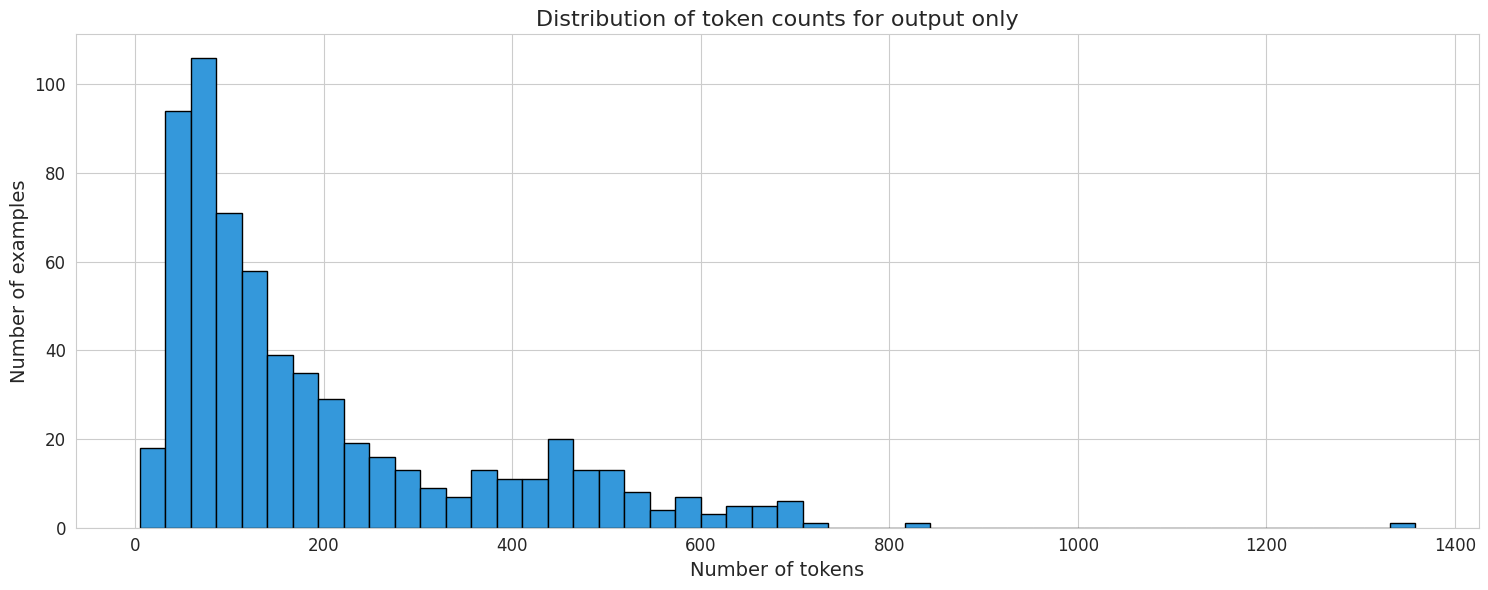

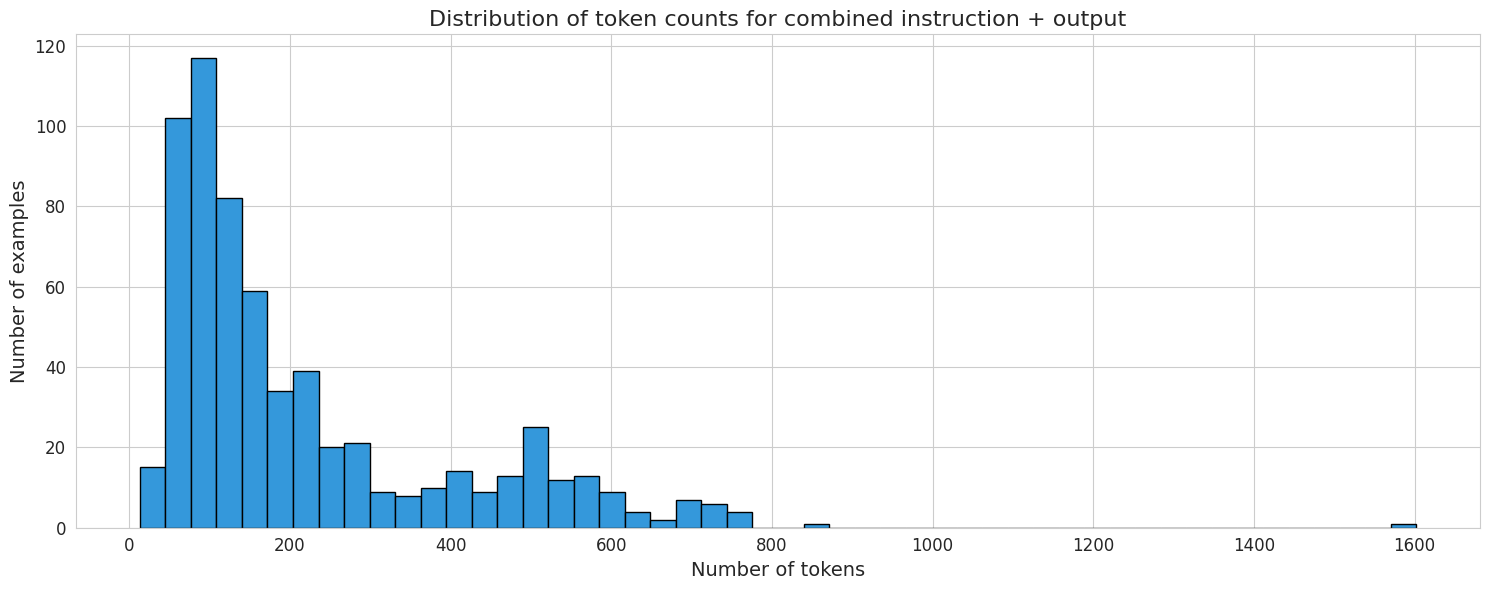

In [5]:
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("NousResearch/Llama-2-7b-hf")

# 2. Tokenize each row and count the number of tokens
instruction_token_counts = [len(tokenizer.tokenize(example["instruction"])) for example in dataset['train']]
output_token_counts = [len(tokenizer.tokenize(example["output"])) for example in dataset['train']]
combined_token_counts = [instruction + output for instruction, output in zip(instruction_token_counts, output_token_counts)]

# Helper function to plot the distributions
def plot_distribution(token_counts, title):
    sns.set_style("whitegrid")
    plt.figure(figsize=(15, 6))
    plt.hist(token_counts, bins=50, color='#3498db', edgecolor='black')
    plt.title(title, fontsize=16)
    plt.xlabel("Number of tokens", fontsize=14)
    plt.ylabel("Number of examples", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

# Plot the distribution of token counts
plot_distribution(instruction_token_counts, "Distribution of token counts for instruction only")
plot_distribution(output_token_counts, "Distribution of token counts for output only")
plot_distribution(combined_token_counts, "Distribution of token counts for combined instruction + output")

## Near-deduplication using embeddings

How to choose the embedding model? Check the [MTEB leaderboard](https://huggingface.co/spaces/mteb/leaderboard). In this example, we're not using the best embedding model because it would take too long.

![](https://i.imgur.com/Fbx1Ivz.png)

In [6]:
from sentence_transformers import SentenceTransformer
import faiss
from datasets import Dataset, DatasetDict
from tqdm.autonotebook import tqdm
import numpy as np

duplicates = []


# Near-duplicates are identified by comparing cosine similarities between sentence embeddings; if similarity exceeds a threshold, items are considered duplicates.

def deduplicate_dataset(dataset: Dataset, model: str, threshold: float):
    sentence_model = SentenceTransformer(model)
    instruction = [example["instruction"] for example in dataset['train']]

    print("Converting text to embeddings...")
    embeddings = sentence_model.encode(instruction, show_progress_bar=True)
    dimension = embeddings.shape[1]
    index = faiss.IndexFlatIP(dimension)
    normalized_embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
    index.add(normalized_embeddings)

    print("Filtering out near-duplicates...")
    D, I = index.search(normalized_embeddings, k=2)
    to_keep = []

    for i in tqdm(range(len(embeddings)), desc="Filtering"):
        # If the second closest vector (D[i, 1]) has cosine similarity above the threshold
        if D[i, 1] >= threshold:
            # Check if either the current item or its nearest neighbor is already in the to_keep list
            nearest_neighbor = I[i, 1]
            if i not in to_keep and nearest_neighbor not in to_keep:
                # If not, add the current item to the list
                to_keep.append(i)
            else:
                duplicates.append(i)
        else:
            # If the similarity is below the threshold, always keep the current item
            to_keep.append(i)

    dataset = dataset['train'].select(to_keep)
    return DatasetDict({"train": dataset})

deduped_dataset = deduplicate_dataset(dataset, "thenlper/gte-large", 0.95)

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/67.9k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

onnx/config.json:   0%|          | 0.00/632 [00:00<?, ?B/s]

model.onnx:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

onnx/special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

onnx/tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

onnx/tokenizer_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

onnx/vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/670M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

Converting text to embeddings...


Batches:   0%|          | 0/20 [00:00<?, ?it/s]

Filtering out near-duplicates...


Filtering:   0%|          | 0/636 [00:00<?, ?it/s]

In [7]:
len(duplicates)

105

In [8]:
Duplicates_dataset = DatasetDict({"train": dataset['train'].select(duplicates)})
df = Duplicates_dataset['train'].to_pandas()

In [9]:
# Sort the DataFrame based on the 'text' column
# df = df.sort_values(by='instruction')

# Display the full text
for full_text in df['instruction'][:10]:
    print(full_text)

Create a HTML page that contains a text box and a submit button.
Create a HTML page with text "Hello, World!"
Create a HTML web page that displays "Welcome To My Page" with a heading level 2.
Generate an HTML page with a heading and a paragraph.
Write an HTML page that displays a single line of text saying "Hello World".
Create an HTML page to list the students in a class list in a table.
Use HTML to create a webpage with a text input field and a button.
Construct an HTML page with a table that displays employee information, including name, age, and salary.
Use HTML to create a basic web page which displays a welcome message and a button to redirect the user to another page.
Write an HTML page containing a heading with the text "Welcome".


In [10]:
print(f"Number of samples in the original dataset: {len(dataset['train'])}")
print(f"Number of samples in the deduped dataset: {len(deduped_dataset['train'])}")
print(f"Number of samples that were removed: {len(dataset['train']) - len(deduped_dataset['train'])}")

Number of samples in the original dataset: 636
Number of samples in the deduped dataset: 531
Number of samples that were removed: 105


We can clearly see that there aren't many duplications in the questions. So, we have decided to drop this idea.

In [11]:
df = dataset['train'].to_pandas()
df

,input,instruction,output,response
0,,Generate the HTML code for a page with a cente...,<html>\n <head>\n <title>My Portfolio</tit...,None
1,<html>\n<head>\n <title>My Web Page</title>...,Edit the following HTML structure to include t...,<html>\n<head>\n <title>My Web Page</title>...,None
2,,Create an HTML page containing a login form wi...,<html>\n <head>\n <title>Login Form</title>\n...,None
3,,Create an HTML page with a text input form and...,<html>\n <head>\n <title>Text Input Form</tit...,None
4,,Write an HTML page that displays a table conta...,<html>\n<head>\n <title>Example Table</title>...,None
...,...,...,...,...
631,,Please generate a html. Can you create an emai...,<!DOCTYPE html>\n<html>\n<head>\n<title>Nutrit...,None
632,,Please generate a html. I want an email templa...,<!DOCTYPE html>\n<html>\n<head>\n<title>Custom...,None
633,,Please generate a html. I need an email templa...,<!DOCTYPE html>\n<html>\n<head>\n<title>Travel...,None
634,,Please generate a html. Can you create an emai...,<!DOCTYPE html>\n<html>\n<head>\n<title>Custom...,None


In [12]:
# I used the prompt template suggested by the officials. Find more details at https://gpus.llm-utils.org/llama-2-prompt-template/

llama2_prompt_without_input = """[INST] <> {instruction} <> [/INST] {output} """
llama2_prompt_with_input = """[INST] <> {instruction} <> {input} [/INST] {output} """

In [13]:
import itertools
examples = list(itertools.islice(dataset['train'], len(dataset['train'])))

In [14]:
print(examples[0]['instruction'])
print(examples[0]['input'])
print(examples[0]['output'])

Generate the HTML code for a page with a centered headline that says "My Portfolio".

<html>
  <head>
    <title>My Portfolio</title>
  </head>
  <body>
    <center>
      <h1>My Portfolio</h1>
    </center>
  </body>
</html>


In [15]:
transformed_dataset = []
for i in examples:
  if not i['input']:
    processed_prompt = llama2_prompt_without_input.format(instruction = i['instruction'], output = i['output'])
  else:
    processed_prompt = llama2_prompt_with_input.format(instruction = i['instruction'], input = i['input'], output = i['output'])

  transformed_dataset.append({'text': processed_prompt})

In [16]:
!pip install -q jsonlines
import jsonlines
with jsonlines.open(f'html_dataset.jsonl', 'w') as writer:
  writer.write_all(transformed_dataset)

In [17]:
filename = 'html_dataset.jsonl'

html_dataset_for_llama2_finetuning = load_dataset("json", data_files = filename)

html_dataset_for_llama2_finetuning

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 636
    })
})

In [18]:
df = html_dataset_for_llama2_finetuning['train'].to_pandas()
df

,text
0,[INST] <> Generate the HTML code for a page wi...
1,[INST] <> Edit the following HTML structure to...
2,[INST] <> Create an HTML page containing a log...
3,[INST] <> Create an HTML page with a text inpu...
4,[INST] <> Write an HTML page that displays a t...
...,...
631,[INST] <> Please generate a html. Can you crea...
632,[INST] <> Please generate a html. I want an em...
633,[INST] <> Please generate a html. I need an em...
634,[INST] <> Please generate a html. Can you crea...


In [19]:
from sklearn.model_selection import train_test_split

# Splitting into training (60%), testing (20%), and validation (20%) sets
train_data, temp_data = train_test_split(df, test_size=0.3)
test_data, validation_data = train_test_split(temp_data, test_size=0.5)

# Display the sizes of the resulting sets
print("Training set size:", len(train_data))
print("Testing set size:", len(test_data))
print("Validation set size:", len(validation_data))

Training set size: 445
Testing set size: 95
Validation set size: 96


In [20]:
train_data

,text
514,[INST] <> Create a simple webpage to welcome v...
544,[INST] <> Please generate a html. Can you crea...
489,[INST] <> Change the following HTML page to an...
607,[INST] <> Please generate a html. Can you crea...
77,[INST] <> Create a HTML page using a basic tex...
...,...
243,[INST] <> Edit the following HTML document and...
223,[INST] <> Write an HTML page which contains a ...
241,[INST] <> Generate an HTML page which contains...
360,[INST] <> Construct an HTML table that contain...


In [21]:
import datasets

train_dataset = Dataset.from_dict(train_data[:2000])
test_dataset = Dataset.from_dict(test_data[:200])
validation_dataset = Dataset.from_dict(validation_data[:200])
final_data = datasets.DatasetDict({"train":train_dataset,"test":test_dataset, "validation": validation_dataset})

In [22]:
final_data

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 445
    })
    test: Dataset({
        features: ['text'],
        num_rows: 95
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 96
    })
})

In [37]:
final_data.push_to_hub('Guna0pro/HTML-Data', token = hf_token)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/Guna0pro/HTML-Data/commit/8bd970b4a592fca68223938e67c7b0046d66eef6', commit_message='Upload dataset', commit_description='', oid='8bd970b4a592fca68223938e67c7b0046d66eef6', pr_url=None, pr_revision=None, pr_num=None)